# Accounting for Autocorrelation: Effective Sample Size

Recall that persistence/autocorrelation in a data set means that our sample size is actually an overestimate, because each data point is not independent of those around it. To deal with this problem, we can decrease $N$ to reflect the degree of autocorrelation in our data.

The most convenient way to do this is to introduce an **effective sample size, $N^*$**, where $N^*$ < $N$. So, we substitute $N^*$ in the place of $N$ in the formulas for the standard errors of the mean, regression, slope, intercept, etc. and in the degrees of freedom for the $t$-statistic.

So, you are probably asking yourself, where does the *red noise* come in? The estimation of $N^*$ is generally approached assuming that a given time series behaves like a red noise time series. 

Using [this assumption](https://journals.ametsoc.org/jamc/article/12/6/1066/349434/The-Standard-Error-of-Time-Average-Estimates-of), $N^*$ can be estimated using the following [approximation](https://www.elsevier.com/books/statistical-methods-in-the-atmospheric-sciences/wilks/978-0-12-751965-4):

$$
\frac{N^*}{N} = \frac{1-\rho(\Delta t)}{1+\rho(\Delta t)}
$$

where $N$ is the number of data points in the time series, $\Delta t$ is the time step and $\rho(\Delta t)$ is the lag-1 autocorrelation, i.e., the coefficient $a$ in the equation for a red noise time series.

### Properties of $N^*$

- for white noise, $\rho(\Delta t)$ = 0 -> N* = N
- as $\rho(\Delta t)$ increases, $N^*$ decreases

## Example Revisited: Lower Tropospheric Temperature Data

Let's take a look at how substituting $N^*$ for $N$ affects the confidence intervals on the slope we calculated in our previous example of the TLT temperature time series.

In [1]:
# Load packages
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font',size=14,weight='bold') #set default font size and weight for plots

First, we need to load in our TLT temperature time series again and convert to seasonal averages.

In [2]:
# Read in TLT file
filename = 'TLT_19792019.csv'
T = np.squeeze(np.genfromtxt(filename,delimiter=','))

# Extract Dec. 1979 - November 2019 and just extract last column (temperature data)
T = T[11:-1,2]

# Alternative way to compute the seasonal averages
T_seasons = np.mean(T.reshape(-1, 3), axis=1)

Next, we will plot the data again and calculate the best-fit line.

Text(0.5, 1.0, 'Seasonal TLT Time Series (1980-2019)')

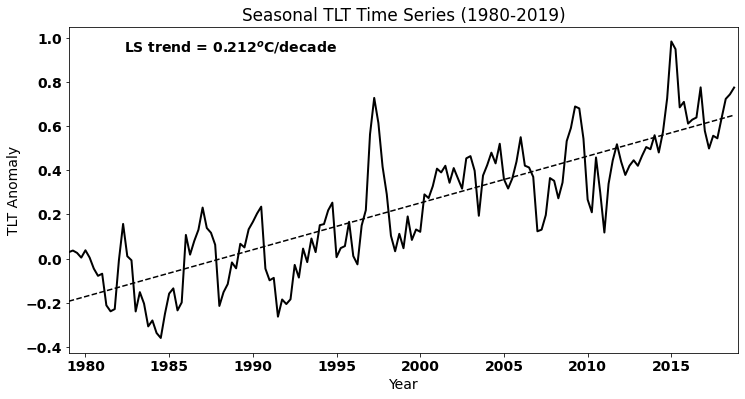

In [3]:
# Create time index for plotting and for regression
time = np.arange(0,len(T_seasons),1)

#  Plot the data (update to Fig. 3 of Santer et al. 2000)
plt.figure(figsize=(12,6))

# plot time series
plt.plot(time,T_seasons,'k',linewidth=2)

# calculate best-fit line
a = np.polyfit(time,T_seasons,1)
T_hat = np.polyval(a,time)

# plot best-fit line
plt.plot(time,T_hat,'k',linestyle='--')

# ticks, labels, etc.
plt.xticks(np.arange(4,len(time),20),["1980","1985","1990","1995","2000","2005","2010","2015"])
plt.xlim(0,len(time)) 
plt.text(0.4, 0.925,'LS trend = ' + str(np.round(a[0]*40,3)) + '$^o$C/decade', ha='right', 
         transform=plt.gca().transAxes, color = 'k') #we multiply by 40 because our unit of time is seasons but we
                                                        #want to report the trend in deg C per decade
plt.ylabel("TLT Anomaly")
plt.xlabel("Year")
plt.title("Seasonal TLT Time Series (1980-2019)")

To calculate $N^*$, we need to know the lag-1 autocorrelation, so let's calculate the ACF for the TLT time series again and extract the lag-1 autocorrelation.

In [4]:
#np.correlate actually gives the covariance. We need to find the covariance of the deviations from the mean and then
#divide the the tau=0 covariance, i.e., the variance to get the correlation

Tcorr = np.correlate((T_seasons-np.mean(T_seasons)),(T_seasons-np.mean(T_seasons))/(len(T_seasons)*np.var(T_seasons)),'same')

In [5]:
# Extract the lag-1 autocorreltation (remember Tcorr goes from lag = -N/2 to + N/2)

Tcorr_lag1 = Tcorr[int(len(T_seasons)/2)+1]
print(np.round(Tcorr_lag1,2))

0.91


This is a very large lag-1 autocorrelation, so our effective sample size will likely be much, much smaller than our originial sample size. To calculate $N^*$, we simply plug this lag-1 autocorrelation into the equation above to get $N^*$.

In [6]:
# calculate the effective sample size

Ne = len(T_seasons) * (1 - Tcorr_lag1)/(1 + Tcorr_lag1)

Let's compare $N^*$ to $N$.

In [7]:
print(np.round(Ne), len(T_seasons))

7.0 160


Wow! That is quite a big difference. So, now let's see how much this change in $N$ affects the confidence intervals on the slope that we calculated. As a reminder, this is what we did to find the confidence intervals using $N$.

In [8]:
#use the alternate way to calculate the best fit parameters
slope, intercept, r_value, p_value, std_err = stats.linregress(time,T_seasons)

#find t_crit for our 95% confidence intervals on our slope
t_crit = stats.t.ppf(0.975,len(time)-2)
confidence_interval = t_crit*std_err
print("The true value of the slope is then", np.round(slope*40,3), "+/-", np.round(confidence_interval*40,3), "degC/decade")

The true value of the slope is then 0.212 +/- 0.021 degC/decade


We get a fairly narrow confidence interval around this slope. In other words, we are quite confident that the true value of the slope is 0.212 degC/decade.

If we instead calculate the standard error of the slope and the critical $t$-value using $N^*$, we will see that the confidence interval widens. We will need to calculate the standard error of the slope using the [formula](https://kls2177.github.io/Climate-and-Geophysical-Data-Analysis/chapters/Week3/confidence_intervals.html).

In [9]:
# Calculate residuals
resids = T_seasons - T_hat

We will call our new standard error of the slope, `std_err_ne`.

In [10]:
# Now we need to recalculate our standard error of the slope...

std_err_ne = np.sqrt(np.sum(resids**2)/((Ne-2)*np.sum((time -np.mean(time))**2)))

Notice that the standard error of the slope gets larger when we use $N^*$.

In [11]:
# Compare std_err_ne with std_err
print(np.round(std_err_ne,4), np.round(std_err,4))

0.0015 0.0003


Next, we calculate the critical $t$-value using $N^*$ for the degrees of freedom. Again, notice the the critical $t$-value is now larger.

In [12]:
# Recalculate t-crit
t_crit_ne = stats.t.ppf(0.975,Ne-2)

# Compare t_crit_ne with t_crit
print(np.round(t_crit_ne,2), np.round(t_crit,2))

2.51 1.98


Finally, we can recalculate the confidence interval on the slope using the adjusted standard error and critical $t$-value.

In [13]:
confidence_interval_ne = t_crit_ne*std_err_ne
print("The true value of the slope is then", np.round(slope*40,3), "+/-", np.round(confidence_interval_ne*40,3), "degC/decade")

The true value of the slope is then 0.212 +/- 0.146 degC/decade


Even though our effective sample size is quite small, we still find that our slope is significantly positive. But, notice that the confidence interval is now quite wide, indicating that we are less confident that the true value of the slope is 0.212 - it could be as low as 0.066 or as high as 0.358 - degC/decade.

In the climate science and geophysics literature, you may notice two ways to use the effective sample size. Here, we have calculated $N^*$ using the lag-1 autocorrelation function of the time series; however, sometimes the lag-1 autocorrelation of the residuals is used instead. In the above example, using the lag-1 autocorrelation of the time series leads to a more conservative estimate of the confidence interval than if we had used the lag-1 autocorrelation of the residuals (go back and compare the ACF's for the TLT temperature and the residuals to convince yourself that this is true). 